In [1]:
%pip install treys
%pip install pokerkit

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [11]:
from pokerkit import Automation, NoLimitTexasHoldem, State, calculate_hand_strength, parse_range, Card, Deck, StandardHighHand
from typing import List
from tqdm import tqdm
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt
import json

import torch
import torch.nn as nn
import torch.optim as optim

#### Agent Definition

In [3]:
class Action(Enum):
    FOLD = 0
    CALL = 1
    BET = 2

In [4]:
class Agent:
    def __init__(self, name: str = None, starting_stack: int = 0):
        self.name = name
        self.starting_stack = starting_stack
        self.stack = starting_stack

    def reset(self):
        self.stack = self.starting_stack
        return self
    
    def pi_action_generator(self, state: State) -> dict:
        pass

    def get_player_state(self, state: State, player_index: int) -> List:
        # Calculate percent chance of winning
        win_percent = self._calculate_strength(state, player_index)
        
        stack = state.stacks[player_index]
        pot = state.total_pot_amount

        min_bet = state.min_completion_betting_or_raising_to_amount
        max_bet = state.max_completion_betting_or_raising_to_amount
        
        if min_bet is None:
            min_bet = 4
        if max_bet is None:
            max_bet = stack
        
        return [win_percent, stack, pot, min_bet, max_bet]

    def _get_valid_actions(self, state: State):
        if state.can_fold():
            yield Action.FOLD
        if state.can_check_or_call():
            yield Action.CALL
        if state.can_complete_bet_or_raise_to():
            yield Action.BET

    def _calculate_strength(self, state: State, player_index: int, samples: int = 500) -> float:
        return calculate_hand_strength(
            state.player_count,
            parse_range(''.join([str(c.rank + c.suit) for c in state.hole_cards[player_index]])),
            Card.parse(''.join([str(c[0].rank + c[0].suit) for c in state.board_cards])),
            2,
            5,
            Deck.STANDARD,
            (StandardHighHand,),
            sample_count=samples
        )

In [5]:
class ExampleRandomAgent(Agent):
    def __init__(self, name: str = None, stack: int = 1000):
        super().__init__(name, stack)

    def pi_action_generator(self, state: State) -> dict:
        valid_actions = list(self._get_valid_actions(state))
            
        valid_bet_low = state.min_completion_betting_or_raising_to_amount
        valid_bet_high = state.max_completion_betting_or_raising_to_amount
        chosen_action = np.random.choice(valid_actions)

        bet_size = 0
        if chosen_action is Action.BET:
            bet_size = round(np.random.uniform(valid_bet_low, valid_bet_high))

        table_action = {
            'table_action': chosen_action,
            'bet_size': bet_size
        }
        return table_action

In [6]:
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
class PolicyNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(PolicyNetwork, self).__init__()
        self.hidden_layer = nn.Linear(input_size, hidden_size)    #the hidden layer with hidden_size neurons
        #nn.init.xavier_uniform_(self.hidden_layer.weight)     # Initialize the weights with Xavier initialization
        nn.init.normal_(self.hidden_layer.weight, mean = 0, std = 0.01)
        nn.init.normal_(self.hidden_layer.bias, mean = 0, std = 0.01)
        self.action_output = nn.Linear(hidden_size, 3)    #the output layer with outputs as prob of stopping, mean, and variance of normal
        self.bet_output = nn.Linear(hidden_size, 1)    #the output layer with outputs as prob of stopping, mean, and variance of normal

        
    #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    def forward(self, s):
        '''A function to do the forward pass
            Takes:
                s -- the state representation
            Returns:
                a tensor of probabilities
        '''
        s = torch.relu(self.hidden_layer(s))    #pass through the hidden layer
        a = self.action_output(s)
        a = torch.softmax(a, dim=1)
        
        b = self.bet_output(s)
        b = torch.exp(b)/(1 + torch.exp(b))
        return a, b

In [39]:
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
class PolicyAgent(Agent):
    #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@    
    def __init__(self, name, stack, config):
        super().__init__(name, stack)    #init the parent class
        self.config = config
        self.mu_s2 = PolicyNetwork(5, self.config['hidden_layer_size'])    #init the policy model
        self.optimizer = optim.Adam(self.mu_s2.parameters(), lr=self.config['learning_rate'])    #init the optimizer

    #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@   
    def action_probs(self, a, s):
        '''A function to compute the logged action probabilities.  This will used used for gradient updates.
            Takes:
                a -- -1 (stop) or float in [0,1]
                state -- float in [0,100]
            Returns:
                torch tensor
        '''
        actions, bet_ratio = self.mu_s2(torch.tensor(np.array([s])))    #compute stop prob, mean, sd

        if a[0] == Action.FOLD:   #if the action was to stop...
            log_p = torch.log(actions[0][0])
        elif a[0] == Action.CALL:    #if the action was to ask for a...
            log_p = torch.log(actions[0][1])
        else:    #if the action was to ask for a in [0,1]...
            action_log_p = torch.log(actions[0][2])

            low = torch.max(bet_ratio[0][0] - self.config['action_var'], torch.tensor([0.0]))
            high = torch.min(bet_ratio[0][0] + self.config['action_var'], torch.tensor([1.0]))
            U = torch.distributions.Uniform(low, high)
            bet_log_p = U.log_prob(torch.tensor(a[1])) 

            log_p = (action_log_p + bet_log_p)[0]
        return log_p

    #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@   
    def pi_action_generator(self, s: State):
        '''A function to generate an action.  This will be used to generate the data.
            Takes:
                state -- float in [0,100]
            Returns:
                 -1 or a in [0,1]

        '''
        state = self.get_player_state(s, s.actor_index)    #get the state
        
        actions, bet_ratio = self.mu_s2(torch.tensor([state]))    #generate policy parameters
        actions, bet_ratio = torch.squeeze(actions), torch.squeeze(bet_ratio)    #reshape

        fold, call, bet = self._calculate_valid_action_values(s, actions)
        bet_size = 0    #init the bet size
        action_chance = np.random.uniform()    #generate a random number to decide what to do
        if action_chance < float(fold):
            a = Action.FOLD    #set the relevant action
            bet_ratio = 0
        elif action_chance < float(fold) + float(call):
            a = Action.CALL
            bet_ratio = 0
        else:    #if not...
            a = Action.BET    #set the relevant action
            min_bet_size, max_bet_size = state[-2], state[-1]    #pull out the min and max bet sizes

            low = torch.max(bet_ratio - self.config['action_var'],torch.tensor([0.0]))
            high = torch.min(bet_ratio + self.config['action_var'],torch.tensor([1.0]))
            U = torch.distributions.Uniform(low, high)
            bet_ratio = float(U.sample())

            bet_size = int((bet_ratio * (max_bet_size - min_bet_size)) + min_bet_size)    #compute the bet size
            
        return {
            'table_action': a,
            'bet_size': bet_size,
            'bet_ratio': bet_ratio
        }

    #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    def objective(self, log_probs, episode_return, b):
        '''A function to compute the objective
            Takes:
                log_probs -- tensor, the output from the forward pass
                causal_return -- tensor, the causal return as defined in lecture
                b -- float, the baseline as defined in lecture
        '''
        return -torch.sum(log_probs * (episode_return - b))

    #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    def update_pi(self, batch):
        '''A function to update the gradient of the agent.
            Takes:
                batch -- a list of dictionary containing episode histories
        '''
        objective = []    #init the objectives per episode   
        for j in range(self.config['N']):    #loop over games
            batch_j = batch[j]    #pull out episode j
            
            for states, actions, total_return in zip(batch_j['states'], batch_j['actions'], batch_j['total_return']):    #loop over state action pairs
                log_probs = []    #init the log probs for this episode
                for s, a in zip(states[:len(states)-1], actions):    #loop over state action pairs
                    log_prob = self.action_probs(a, s)    #compute the log prob for this state action pair
                    log_probs.append(log_prob)    #record
                log_probs = torch.stack(log_probs)    #reshape to compute gradient over the whole episode
                if self.config['causal_return']:    #if we use causal returns...
                    batch_j_reward = batch_j['causal_return']    #set that
                else:    #if not...
                    batch_j_reward = total_return    #use the total discounted reward

            objective.append(self.objective(log_probs, batch_j_reward, 0))    #compute the objective function and record
        
        objective = torch.mean(torch.stack(objective))    #reshape
        
        #run the backward pass to compute gradients
        self.optimizer.zero_grad()    #zero gradients from the previous step
        objective.backward()    #compute gradients
        self.optimizer.step()    #update policy network parameters\n"
        
    def _calculate_valid_action_values(self, state: State, actions: torch.Tensor):
        valid_actions = list(self._get_valid_actions(state))
        actions = actions.detach().numpy()
        
        valid_action_values = actions[[Action.FOLD in valid_actions, Action.CALL in valid_actions, Action.BET in valid_actions]]
        valid_action_values = valid_action_values / max(valid_action_values)
        valid_action_values = np.exp(valid_action_values)/np.sum(np.exp(valid_action_values))

        fold, call, bet = 0, 0, 0

        num_actions = 0
        if Action.FOLD in valid_actions:
            fold = valid_action_values[num_actions]
            num_actions += 1
        if Action.CALL in valid_actions:
            call = valid_action_values[num_actions]
            num_actions += 1
        if Action.BET in valid_actions:
            bet = valid_action_values[num_actions]
            num_actions += 1

        return fold, call, bet


#### Environment

In [40]:
class TexasHoldemEnvironment():
    def __init__(self, config):
        self.config = config
        self.reset_game()
    
    def reset_game(self):
        self.game = NoLimitTexasHoldem(
            automations= (
                Automation.ANTE_POSTING,
                Automation.BET_COLLECTION,
                Automation.BLIND_OR_STRADDLE_POSTING,
                Automation.CARD_BURNING,
                Automation.HOLE_DEALING,
                Automation.BOARD_DEALING,
                Automation.HOLE_CARDS_SHOWING_OR_MUCKING,
                Automation.HAND_KILLING,
                Automation.CHIPS_PUSHING,
                Automation.CHIPS_PULLING
            ),
            ante_trimming_status=True,  # Uniform antes?
            raw_antes=0,  # Antes
            raw_blinds_or_straddles=self.config['blinds'],  # Blinds
            min_bet=self.config['min_bet'],  # Minimum bet
        )
        self.stacks = np.array([self.config['starting_stack'] for _ in range(self.config['player_count'])])  # Observed Agent stack will always be at position 0
        self.poker_round = None
        
    def reset_round(self, agents: List[Agent]):
        agent_stacks = [agent.stack for agent in agents]
        self.poker_round = self.game(raw_starting_stacks=agent_stacks, player_count=agent_stacks.__len__())

    def step(self, action):
        player_action = action['table_action']
        bet_amount = action['bet_size']

        # Update the environment state with the player action
        if player_action == Action.FOLD:
            self.poker_round.fold()
        elif player_action == Action.CALL:
            self.poker_round.check_or_call()
        elif player_action == Action.BET:
            self.poker_round.complete_bet_or_raise_to(bet_amount)
        
        done = not self.poker_round.status  # Check if the round is done

        # Update the environment stacks if the round is done
        if done:
            self.stacks = self.poker_round.stacks

        return {'state': self.poker_round, 'reward': self.config['ongoing_reward'], 'done': done}

#### Running the Environment

In [41]:
agent_config = {
    'gamma': 0.1,
    'action_var': 1,
    'hidden_layer_size': 16,
    'learning_rate': 0.001,
    'B': 1,
    'N': 1,
    'causal_return': False,
    'baseline': False
}   # Set the configuration for the agent
env_config = {
    'player_count': 4,
    'blinds': (2, 4),
    'min_bet': 4,
    'starting_stack': 200,
    'ongoing_reward': 0.5
}   # Set the configuration for the environment

# Define the players in the game with Agent objects
# The first player in the list will be the tracked player
tracked_agent = PolicyAgent(name='Policy Agent', stack=env_config['starting_stack'], config=agent_config)  # Tracked player
players: List[Agent] = [
    tracked_agent,
    ExampleRandomAgent(name='Random Agent 1', stack=env_config['starting_stack']),
    ExampleRandomAgent(name='Random Agent 2', stack=env_config['starting_stack']),
    ExampleRandomAgent(name='Random Agent 3', stack=env_config['starting_stack'])
]
# Randomly select a player to be the dealer
player_offset = np.random.randint(0, len(players))
# Create the environment with the configuration
env = TexasHoldemEnvironment(env_config)

In [42]:
#run training loop
tracked_agent_stack_sizes = []

for b in tqdm(range(agent_config['B']), desc=f'Poker Batches of {agent_config["N"]} Games'):    #loop over batches
    baseline = 0    #init the baseline
    batch = []    #init the batch
    for _ in range(agent_config['N']):    #loop over episodes
        active_players = [agent.reset() for agent in players]
        game_stack_sizes = [env_config['starting_stack']]
        env.reset_game()
        env.reset_round(active_players)
        
        # gamma_array = []    #init the discounting
        states = []    #init the state history
        actions = []    #init the action history
        rewards = []    #init the reward history
        
        # Play rounds until there is only one player left or the tracked player is eliminated
        while len(active_players) > 1 and tracked_agent in active_players:
            round_done = False   #Set the stopping condition
            
            # game_gamma = [1]    #init the game gamma
            game_states = []    #init the game states
            game_actions = []    #init the game actions
            game_rewards = []    #init the game rewards
            
            # Calculate amount to offset players to get a new dealer
            player_offset = (player_offset + 1) % len(active_players)
            # Rotate players based on offset
            active_players = active_players[player_offset:] + active_players[:player_offset]
            
            # Reset the environment for a round of poker
            env.reset_round(active_players)
            
            # Play the round until the round is over
            while not round_done:
                # Get the current acting player and their index
                current_player_index = env.poker_round.actor_index
                current_player: Agent = active_players[current_player_index]
                
                # If the current player is the tracked player and the state history is empty, record the player's state
                if current_player == tracked_agent and len(game_states) == 0:
                    game_states.append(tracked_agent.get_player_state(env.poker_round, current_player_index))
                
                # Get the action from the current acting player
                action = current_player.pi_action_generator(env.poker_round)
                # Step the environment with the player's action
                update = env.step(action)
                
                # Update the stopping condition
                round_done = update['done']

                # If the current player is the tracked player, record the data
                if current_player == tracked_agent:
                    game_states.append(tracked_agent.get_player_state(update['state'], current_player_index) if action['table_action'] != Action.FOLD and not round_done else np.zeros(5))
                    game_actions.append([action['table_action'], action['bet_ratio']])
                    game_rewards.append(update['reward'] if action['table_action'] != Action.FOLD else 0)
                    # game_gamma.append(gamma_array[-1] * agent_config['gamma'])
                    
            # Update stacks for each player
            for agent, stack in zip(active_players, env.stacks):
                agent.stack = stack
            
            #Set the reward for the last state to be the terminal reward
            if len(game_rewards) > 0:
                game_rewards[-1] = tracked_agent.stack   
            else:
                game_rewards.append(tracked_agent.stack)
                
            game_stack_sizes.append(game_rewards[-1])    #record the stack size at the end of the round
                
            # Update active players in the game by removing players with stacks less than the minimum bet
            active_players = [agent for agent in players if agent.stack > env_config['min_bet']]
            
            if len(game_states) != 0:
                states.append(game_states)    #record the state history
                actions.append(game_actions)
                rewards.append(game_rewards)    #record the reward history
                # gamma_array.append(game_gamma)    #record the discounting

        tracked_agent_stack_sizes.append(game_stack_sizes)
        
        discounted_rewards = [reward * (agent_config['gamma'] ** np.array(range(len(reward)))) for reward in rewards]    #discount the reward history
        # causal_return = [np.cumsum((discounted_reward)[::-1])[::-1] for discounted_reward in discounted_rewards]    #compute the causal return
        # causal_return = torch.tensor(list(causal_return))    #turn into a torch tensor
        # if agent_config['baseline']:    #if we'd like the agent to use baselining...
        #     baseline += sum(discounted_rewards)    #update the baseline with info from this episode

        states = [list(np.array(s).astype(np.float32)) for s in states]    #turn the state history into a numpy array
        
        batch.append({
            'states': states,
            'actions': actions,
            'rewards': rewards,
            'total_return': [sum(reward) for reward in discounted_rewards],
            # 'causal_return': causal_return
        })    #add data from this episode to the batch
        
    # for j in range(agent_config['N']):    #once the batch is made loop over episodes
    #     batch[j]['baseline'] = baseline / agent_config['N']    #add the baseline to each one
    tracked_agent.update_pi(batch)    #run the gradient update\n"

Poker Batches of 1 Games:   0%|          | 0/1 [00:00<?, ?it/s]

/home/krukr/.conda/envs/apollo/lib/python3.11/site-packages/torch/autograd/graph.py:825: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Poker Batches of 1 Games: 100%|██████████| 1/1 [00:09<00:00,  9.22s/it]


In [62]:
with open('outputs/stack_sizes2.json', 'r') as f:
    stack_sizes = json.load(f)

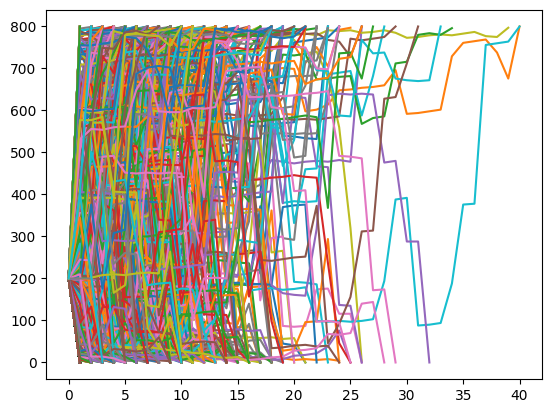

In [63]:
for stack in stack_sizes:
    plt.plot(stack)

In [64]:
rounds_played = [len(stack) for stack in stack_sizes]
games_won = [stack[-1] > env_config['min_bet'] for stack in stack_sizes]

In [65]:
sum(games_won) / len(stack_sizes)

0.30916666666666665

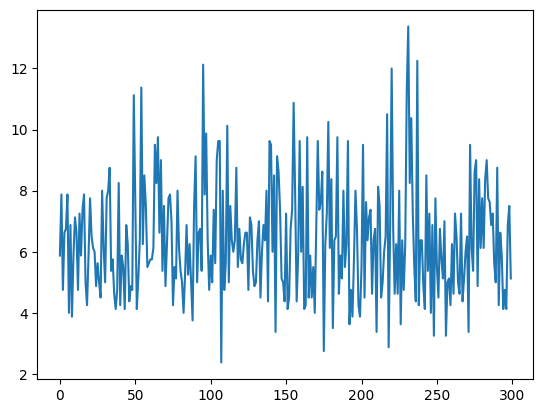

In [66]:
average_rounds_played = []
for i in range(0, len(rounds_played), 8):
    average_rounds_played.append(np.mean(rounds_played[i:i+8]))
plt.plot(average_rounds_played)

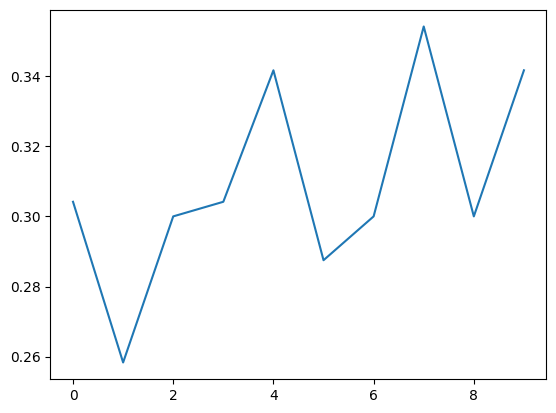

In [68]:
average_games_won = []
for i in range(0, len(games_won), 240):
    average_games_won.append(np.mean(games_won[i:i+240]))
plt.plot(average_games_won)

### Old Code for running with Random Agents, useful for baselining stats

In [ ]:
agent_config = {
    'gamma': 0.1,
    'action_var': 1,
    'hidden_layer_size': 16,
    'learning_rate': 0.001,
    'B': 1,
    'N': 1,
    'causal_return': False,
    'baseline': False
}   # Set the configuration for the agent
env_config = {
    'player_count': 4,
    'blinds': (2, 4),
    'min_bet': 4,
    'starting_stack': 200,
    'ongoing_reward': 0.5
}   # Set the configuration for the environment
# Define the players in the game with Agent objects
tracked_agent = PolicyAgent(name='Policy Agent', stack=env_config['starting_stack'], config=agent_config)  # Tracked player
tracked_agent.mu_s2 = torch.load('outputs/policy2.pt')
players: List[Agent] = [
    tracked_agent,
    ExampleRandomAgent(name='Random Agent 1', stack=env_config['starting_stack']),
    ExampleRandomAgent(name='Random Agent 2', stack=env_config['starting_stack']),
    ExampleRandomAgent(name='Random Agent 3', stack=env_config['starting_stack'])
]
# Randomly select a player to be the dealer
player_offset = np.random.randint(0, len(players))
# Create the environment with the configuration
env = TexasHoldemEnvironment(env_config)
# Number of games (episodes) to play
num_games = 1000

tracked_agent_stack_sizes = []

for episode in tqdm(range(num_games)):
    # Reset all players and environment
    game_stack_sizes = [env_config['starting_stack']]
    active_players = [agent.reset() for agent in players]
    env.reset_game()
    env.reset_round(active_players)
    num_rounds = 0   # Number of rounds played in the game

    # Play rounds until there is only one player left or 100 rounds have been played
    while len(active_players) > 1:
        done = False
        # Calculate amount to offset players to get a new dealer
        player_offset = (player_offset + 1) % len(active_players)
        # Rotate players based on offset
        active_players = active_players[player_offset:] + active_players[:player_offset]
        # Reset the environment for a round of poker
        env.reset_round(active_players)

        # Play the round until the round is over
        while not done:
            # Get the current acting player and their action
            current_player: Agent = active_players[env.poker_round.actor_index]
            action = current_player.pi_action_generator(env.poker_round)
            # Step the environment with the player's action
            current_state = env.step(action)
            # Update the player's observations, actions, and rewards
            done = current_state['done']

        # Update stacks for each player
        for agent, stack in zip(active_players, env.stacks):
            agent.stack = stack
            
        game_stack_sizes.append(tracked_agent.stack)

        # Update active players in the game by removing players with 0 stack
        active_players = [agent for agent in players if agent.stack > env_config['min_bet']]
        num_rounds += 1
        
    tracked_agent_stack_sizes.append(game_stack_sizes)

/tmp/ipykernel_1746850/3993082166.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tracked_agent.mu_s2 = torch.load('outputs/policy2.pt')
  0%|          | 0/1000 [00:00<

  1%|          | 9/1000 [00:21<42:03,  2.55s/it]